In [1]:
import numpy as np
import matplotlib.pyplot as plt

from synthlearners import Synth
from synthlearners.simulator import (
    SimulationConfig,
    PanelSimulator,
    FactorDGP,
)
from synthlearners.plotting import SynthPlotter

## Basic use with Panel Matrices

In [2]:
config = SimulationConfig(
    N=100,
    T=50,
    T_pre=40,
    n_treated=10,
    selection_mean=1.0,
    treatment_effect=0.5,
    dgp=FactorDGP(K=2, sigma=1, time_fac_lb=-0.1, time_fac_ub=0.1, trend_sigma=0.0001),
)
simulator = PanelSimulator(config)
Y, Y_0, L, treated_units = simulator.simulate()

In [3]:
treated_units

array([89, 32, 13, 80, 85, 28, 82, 45,  9, 64])

In [4]:
from synthlearners.mcnnm import MatrixCompletionEstimator

In [5]:
# Create a mask indicating which entries are observed.
mask = np.ones_like(Y)
missing_periods = config.T-config.T_pre

# For treated units, suppose the outcomes in the last N periods are missing.
mask[treated_units, -missing_periods:] = 0  

In [6]:
mask[treated_units[0]]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
estimator = MatrixCompletionEstimator(
    lambda_param=2e-3,
    max_iter=500,
    tol=1e-6,
    verbose=True
)
estimator.fit(Y, mask)
Y_completed = estimator.completed_matrix_

shrink_treshhold: 4.9
singular values: [18.45630604 16.65381304 16.00477896 14.80961648 14.48945987 14.0791722
 13.75626243 13.6379817  13.37233231 13.10356627 12.678559   12.36360329
 12.20301516 11.82651326 11.59477526 11.27431882 11.11883276 10.74491117
 10.72874834 10.43801928 10.23894824 10.11201172  9.68377456  9.45119317
  9.3744657   9.10835925  8.95171259  8.6591062   8.38759565  8.23260729
  8.10910131  7.72932991  7.5446034   7.21155163  7.18248946  6.83030331
  6.62835427  6.3095348   6.11579272  5.52635758  5.4781425   5.31919768
  4.96973172  4.63151484  4.47611388  4.25386795  3.96647809  3.86797836
  3.47221256  3.26546619]
s_thresholded: [13.55630604 11.75381304 11.10477896  9.90961648  9.58945987  9.1791722
  8.85626243  8.7379817   8.47233231  8.20356627  7.778559    7.46360329
  7.30301516  6.92651326  6.69477526  6.37431882  6.21883276  5.84491117
  5.82874834  5.53801928  5.33894824  5.21201172  4.78377456  4.55119317
  4.4744657   4.20835925  4.05171259  3.759106

In [8]:
# Counterfactual Values for imputed periods for single treated example
Y_0[treated_units[0], -missing_periods:]

array([-0.76488391, -0.15174888, -0.13119737,  0.30966483,  0.12721515,
        0.81209996,  0.97510635, -1.01615275,  0.85462799, -1.3490142 ])

In [9]:
# Observed Value for imputed periods from single treated example
Y[treated_units[0], -missing_periods:]

array([-0.26488391,  0.34825112,  0.36880263,  0.80966483,  0.62721515,
        1.31209996,  1.47510635, -0.51615275,  1.35462799, -0.8490142 ])

In [10]:
# MC Values for imputed periods for single treated example
Y_completed[treated_units[0], -missing_periods:]

array([ 0.12295758, -0.22432011, -0.322544  ,  0.3633754 ,  0.34699387,
        0.24513517,  0.00243552, -0.36594639,  0.26558588, -0.56419653])

In [11]:
baseline_bias = Y_completed[treated_units[0], -missing_periods:]-Y_0[treated_units[0], -missing_periods:]
print('Baseline Bias of MC value relative to actual counterfactual',np.mean(baseline_bias))

Baseline Bias of MC value relative to actual counterfactual 0.02037592140397776


In [12]:
te = Y[treated_units[0], -missing_periods:]-Y_completed[treated_units[0], -missing_periods:]
print('Estimated Treatment Effect of Observed relative to MC Value',np.mean(te))

Estimated Treatment Effect of Observed relative to MC Value 0.47962407859602224


In [13]:
print('Treatment Effect Bias',np.abs(np.mean(te)-config.treatment_effect))

Treatment Effect Bias 0.02037592140397776


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from synthlearners import Synth
from synthlearners.utils import prepare_panel

In [15]:
adh_data = pd.read_csv("ADH2015.csv", index_col=0)
adh_data = adh_data[['country', 'year', 'gdp']]
# manually create treatment indicator
adh_data['treat'] = np.where((adh_data.country == "West Germany") & (adh_data.year > 1990), 1, 0)
adh_data.head()

,country,year,gdp,treat
index,,,,
1.0,USA,1960.0,2879,0
1.0,USA,1961.0,2929,0
1.0,USA,1962.0,3103,0
1.0,USA,1963.0,3227,0
1.0,USA,1964.0,3420,0


In [16]:
data = prepare_panel(
    adh_data,
    unit_col="country",
    time_col="year",
    outcome_col="gdp",
    treatment_col="treat",
)

Text(0.5, 1.0, 'Treatment matrix')

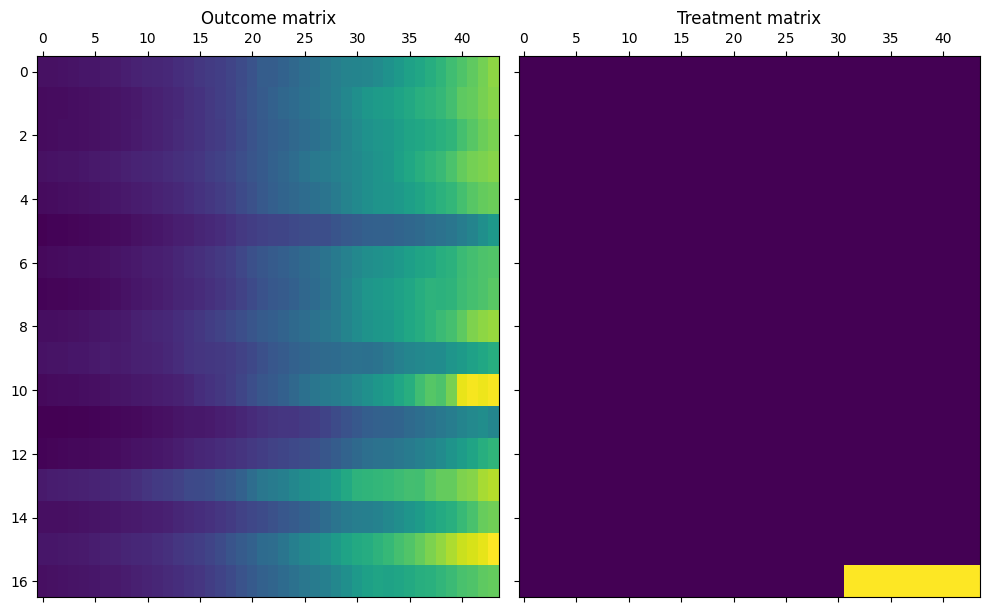

In [17]:
f, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
ax[0].matshow(data["Y"], aspect="auto", cmap="viridis")
ax[1].matshow(data["W"], aspect="auto", cmap="viridis")
f.tight_layout()
ax[0].set_title("Outcome matrix")
ax[1].set_title("Treatment matrix")

In [18]:
# Fit synthetic control - basic
synth = Synth(method="simplex")
results = synth.fit(
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    compute_jackknife=False,
    compute_permutation=True
)

You have 17 units, so the lowest possible p-value is 0.0625, which is smaller than traditional α of 0.05 
Permutation test may be unreliable


Computing permutation test:   0%|          | 0/16 [00:00<?, ?it/s]

In [19]:
# Fit synthetic control
mc_synth = Synth(method="matrix_completion")
mc_results = mc_synth.fit(
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    compute_jackknife=False,
    compute_permutation=True,
    verbose=True
)

Y control std: 8946.142870014328
shrink_treshhold: 3675.0
singular values: [3.99079110e+05 5.14523545e+04 1.18227044e+04 7.50885825e+03
 4.65404371e+03 3.22420770e+03 2.50457039e+03 2.00376346e+03
 1.49483729e+03 1.23590639e+03 1.11695674e+03 1.04497328e+03
 8.13534970e+02 5.78352353e+02 5.39354527e+02 4.70891196e+02
 2.94150650e+02]
s_thresholded: [395404.11012062  47777.35453227   8147.70436841   3833.85824555
    979.04371324      0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.        ]
Iteration   1, relative change = 39838314219918.429688
singular values: [3.99181716e+05 5.07117423e+04 1.16843937e+04 7.50491004e+03
 4.65307252e+03 3.22382745e+03 2.50392092e+03 2.00088549e+03
 1.49367611e+03 1.23507727e+03 1.11666186e+03 1.04519599e+03
 8.13553223e+02 5.78702091e+02 5.39229748e+02 4.70687550e+02
 2.94052834e+02]
s_thresholded: [395506.71630381  47036.74231427   8009.3936622

Computing permutation test:   0%|          | 0/16 [00:00<?, ?it/s]

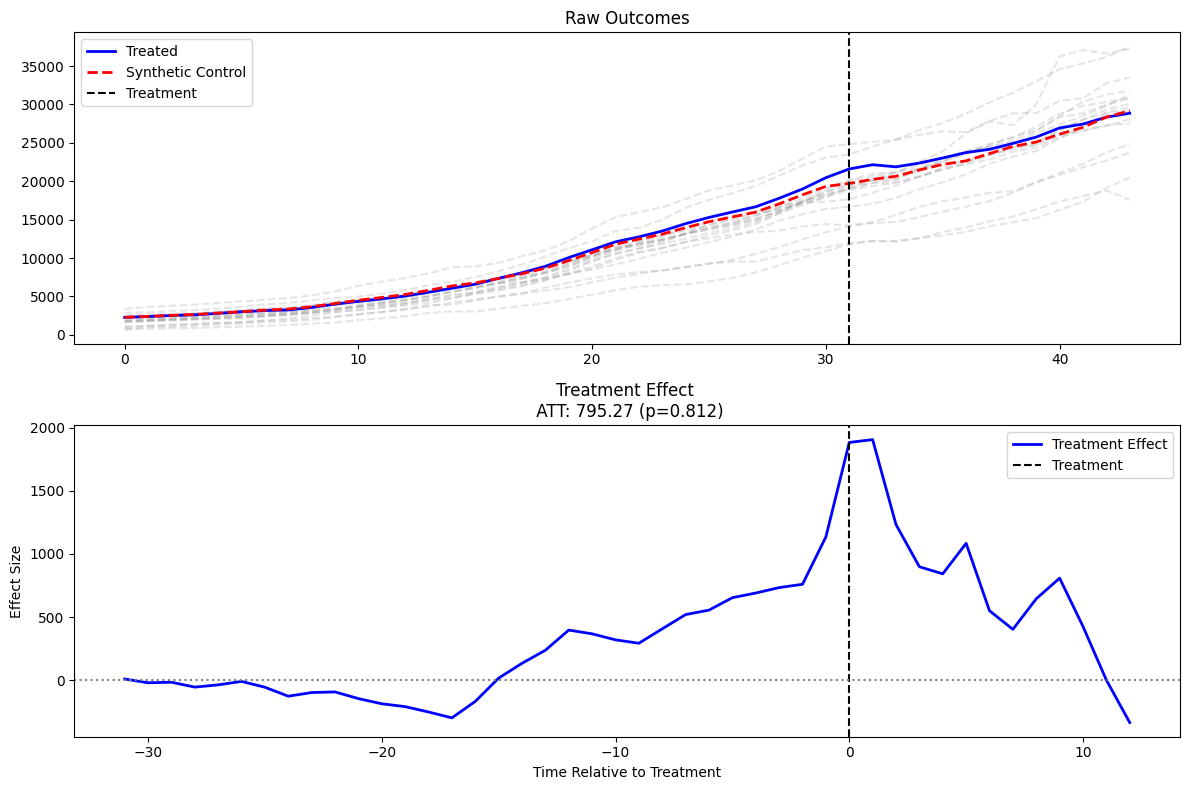

In [20]:
# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Raw outcomes plot
synth.plot(mc_results, data["Y"], data["treated_units"], data["T_pre"], mode="raw", ax=ax1)
ax1.set_title("Raw Outcomes")

# Treatment effect plot
synth.plot(
    mc_results,
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    mode="effect",
    ax=ax2,
    show_ci=True,
)

plt.tight_layout()
plt.show()

In [24]:
# Fit multiple synthetic controls
synth_methods = [
    Synth(method="lp_norm", p=1.0),
    #Synth(method="lp_norm", p=2.0),
    #Synth(method="linear"),
    Synth(method="simplex"),
    Synth(method="matrix_completion"),
]

results = [
    method.fit(data["Y"], data["treated_units"], data["T_pre"], compute_jackknife=False,verbose=False)
    for method in synth_methods
]

Choosing regularization parameter using sequential cross-validation
Y control std: 8946.142870014328


In [25]:
from synthlearners.plotting import SynthPlotter

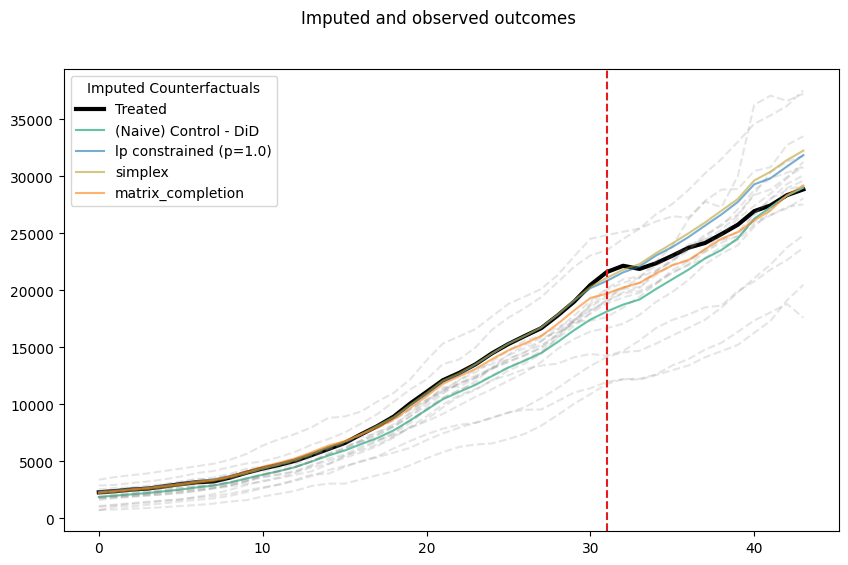

In [26]:
# Create plot
plotter = SynthPlotter()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plotter.plot_trajectories(
    results, data["Y"], data["treated_units"], data["T_pre"],
    ax=ax, show_controls=True
)
fig.suptitle("Imputed and observed outcomes")
plt.show()